# Autoencoder

In [1]:
import numpy as np
import pandas as pd
from typing import Union, Tuple

import time
import copy
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

import shutil
import os
import pickle
from zipfile import ZipFile

In [2]:
data_path = './data/digit_data/'

if os.path.exists(data_path):
    shutil.rmtree(data_path)
    
with ZipFile('./data/digit-recognizer.zip') as f:
    f.extractall(data_path)
    
train_set = pd.read_csv('./data/digit_data/train.csv')

shutil.rmtree(data_path)
train_set.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_data = train_set.drop('label', axis=1).values
train_data = (train_data.astype(float) - 127.5) / 127.5 # normalize to scale [-1, 1]
train_data.shape

(42000, 784)

In [5]:
def mse(y_true, y_pred):
    '''
    Compute mean squared error, y_pred - vector of size n_objects
    '''
    return np.mean(np.power(y_true - y_pred, 2))

def mse_derivative(y_true, y_pred):
    '''
    Compute derivative of MSE
    '''
    return -2 * (y_true - y_pred) / len(y_true)

In [10]:
def leaky_relu(z: Union[np.array, float, int, list], alpha=0.2) -> np.array:
    """
    Leaky ReLU function
    """
    return np.where(z >= 0, z, alpha * z)

def leaky_relu_derivative(z: Union[np.array, float, int, list], alpha=0.2) -> np.array:
    """
    Leaky ReLU function derivative
    """
    return np.where(z >= 0, 1, alpha)   

def tanh(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function
    """
    return np.tanh(z)

def tanh_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function derivative
    """
    return 1 - np.tanh(z) ** 2

In [7]:
class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass
    

class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.
    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()

In [8]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class Linear(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        
        limit = 1 / np.sqrt(self.n_input) 
        self.w = np.random.uniform(-limit, limit, size=(n_input, n_output))
        self.b = np.zeros(shape=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return x.dot(self.w) + self.b

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        w_grad = self.input.T.dot(output_error)
        b_grad = np.ones((1, len(output_error))).dot(output_error)
        input_error = output_error.dot(self.w.T)

        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)
        return input_error


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)

In [29]:
class BatchNorm(BaseLayer):
    """
    num_features – number of features or channels CC of the input
    num_dims – number of input features
    eps – a value added to the denominator for numerical stability. Default: 1e-5
    momentum – the value used for the running_mean and running_var computation.
    Can be set to None for cumulative moving average (i.e. simple average). Default: 0.1
    affine – a boolean value that when set to True, this module has learnable affine parameters. Default: True

    https://arxiv.org/pdf/1502.03167.pdf'
    """

    def __init__(self, num_features, num_dims, eps=1e-05, momentum=0.1, affine=True):
        super().__init__()
        self.input = None
        self.x_centered = None
        self.x_std = None
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine

        if num_dims == 2:
            shape = (1, num_features)
            self.axis = 0
        elif num_dims == 4:
            shape = (1, num_features, 1, 1)
            self.axis = (0, 2, 3)
        else:
            raise ValueError("num_dims must be in (2, 4)")

        self.gamma = np.ones(shape=shape)
        self.beta = np.zeros(shape=shape)
        self.gamma_optimizer = None
        self.beta_optimizer = None

        self.moving_mean = np.zeros(shape=shape)
        self.moving_var = np.zeros(shape=shape)

    def set_optimizer(self, optimizer) -> None:
        self.gamma_optimizer = copy.copy(optimizer)
        self.gamma_optimizer.set_weight(self.gamma)
        if self.affine:
            self.beta_optimizer = copy.copy(optimizer)
            self.beta_optimizer.set_weight(self.beta)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        if not grad:
            self.x_centered = (x - self.moving_mean)
            self.x_std = np.sqrt(self.moving_var + self.eps)
            x_hat = self.x_centered / self.x_std
        else:
            assert len(x.shape) in (2, 4)

            mean = x.mean(axis=self.axis, keepdims=True)
            var = ((x - mean) ** 2).mean(axis=self.axis, keepdims=True)

            self.x_centered = (x - mean)
            self.x_std = np.sqrt(var + self.eps)
            x_hat = (x - mean) / np.sqrt(var + self.eps)
            self.moving_mean = self.momentum * self.moving_mean + (1 - self.momentum) * mean
            self.moving_var = self.momentum * self.moving_var + (1 - self.momentum) * var

        y = self.gamma * x_hat + self.beta
        return y

    def backward(self, output_error: np.array) -> np.array:
        assert self.gamma_optimizer is not None, 'You should set an optimizer'

        gamma_grad = np.sum(output_error * self.x_centered / self.x_std, axis=self.axis, keepdims=True)
        batch_size = output_error.shape[0]

        # following lines are got from the original paper, they are the same as final version for input error
        #
        # dldx = output_error * self.gamma
        # dldsigma2 = np.sum(dldx * self.x_centered * (-1/2) * (self.x_std ** -3), axis=0)
        # dldmu = np.sum((dldx * (-1/self.x_std)), axis=0) + dldsigma2 * np.sum(-2*self.x_centered, axis=0) / batch_size
        # input_error = dldx / self.x_std + dldsigma2 * 2 * self.x_centered / batch_size + dldmu / batch_size

        input_error = (1 / batch_size) * self.gamma / self.x_std * \
                      (batch_size * output_error - np.sum(output_error, axis=self.axis, keepdims=True) -
                       self.x_centered / self.x_std ** 2 * np.sum(output_error * self.x_centered, axis=self.axis,
                                                                  keepdims=True))

        self.gamma = self.gamma_optimizer.step(gamma_grad)
        if self.affine:
            beta_grad = np.sum(output_error, axis=self.axis, keepdims=True)
            self.beta = self.beta_optimizer.step(beta_grad)
        return input_error

In [51]:
class Autoencoder:
    def __init__(self):
        encoder = [
            Linear(28*28, 512),
            Activation(leaky_relu, leaky_relu_derivative),
            BatchNorm(512, 2, momentum=0.8, affine=False),
            Linear(512, 256),
            Activation(leaky_relu, leaky_relu_derivative),
            BatchNorm(256, 2, momentum=0.8, affine=False),
            Linear(256, 256)
        ]
        decoder = [
            Linear(256, 256),
            Activation(leaky_relu, leaky_relu_derivative),
            BatchNorm(256, 2, momentum=0.8, affine=False),
            Linear(256, 512),
            Activation(leaky_relu, leaky_relu_derivative),
            BatchNorm(512, 2, momentum=0.8, affine=False),
            Linear(512, 28*28),
            Activation(tanh, tanh_derivative),
        ]
        self.layers = encoder + decoder
        self.loss = mse
        self.loss_derivative = mse_derivative
        self.grad = True
        
    def __call__(self, x):
        return self.forward(x)
        
    def fit(self, x, batch_size, n_epochs, echo=True, save_period=100, save_path='./'):
        # saving initial model
        self.save_model(save_path)
        
        batch_size = batch_size or len(x)
        amount_of_batches = np.ceil(len(x) / batch_size).astype(int)

        try:
            for epoch in range(n_epochs):
                start_time = time.time()
                
                # it is good to do permutations in each epoch
                idxs = np.random.permutation(len(x))
                error = 0

                for batch_idx in range(amount_of_batches):
                    batch_slice = idxs[batch_idx * batch_size:batch_idx * batch_size + batch_size]
                    
                    # real_images = [batch_size or less (if batch is last in dataset), 28*28]
                    images = x[batch_slice]
                    num_images = images.shape[0]
                    
                    # learning phase
                    pred = self.forward(images)
                    loss = self.loss(images, pred)
                    output_error = self.loss_derivative(images, pred)
                    self.backward(output_error)
                    
                    error += loss

                if echo:
                    print('*' * 30)
                    print(f"""Epoch {epoch} Time: {time.time()-start_time:.3f}
                    loss:{error / amount_of_batches}""")
                    
                if save_period is not None and (epoch+1) % save_period == 0:
                    self.save_model(save_path)
                    self.save_imgs(images, epoch+1, save_path)
                    
        except KeyboardInterrupt:
            print('Interrupted by user')
            return self

        return self
    
    def forward(self, x):
        self.input = x
        for layer in self.layers:
            x = layer(x, self.grad)
        return x
    
    def backward(self, output_error):
        for layer in reversed(self.layers):
            output_error = layer.backward(output_error)
        return output_error
    
    def set_optimizer(self, optimizer):
        for layer in self.layers:
            if 'set_optimizer' in layer.__dir__():
                layer.set_optimizer(optimizer)
    
    def save_model(self, path):
        with open(f'{path}/autoencoder.pkl', 'wb') as f:
            pickle.dump(self, f)
            
    def save_imgs(self, x, epoch, path):
        generated = self.forward(x).reshape(-1, 28, 28)
        generated = 0.5 * generated + 0.5

        fig, ax = plt.subplots(2, 5, figsize=(25, 10))
        cnt = 0
        for i in range(2):
            for j in range(5):
                ax[i,j].imshow(generated[cnt,:,:], cmap='viridis')
                ax[i,j].axis('off')
                cnt += 1
        fig.savefig(f"{path}/mnist_{epoch}.png", dpi=199)
        plt.close()

In [52]:
optimizer = ADAM(learning_rate=0.0002, beta1=0.5)

autoencoder = Autoencoder()
autoencoder.set_optimizer(optimizer)

In [53]:
autoencoder.fit(train_data, batch_size=128, n_epochs=1000, save_period=1, save_path='./models/autoencoder')

******************************
Epoch 0 Time: 18.634
                    loss:0.24186237046796055
******************************
Epoch 1 Time: 18.673
                    loss:0.1426561487641078
******************************
Epoch 2 Time: 18.326
                    loss:0.12167831614771471
******************************
Epoch 3 Time: 18.399
                    loss:0.13352662359731693
******************************
Epoch 4 Time: 18.322
                    loss:0.12070485176157751
******************************
Epoch 5 Time: 18.346
                    loss:0.10947744362983639
******************************
Epoch 6 Time: 18.342
                    loss:0.09477068252057351
******************************
Epoch 7 Time: 18.328
                    loss:0.09513769862043815
******************************
Epoch 8 Time: 18.332
                    loss:0.09414071991840131
******************************
Epoch 9 Time: 18.359
                    loss:0.08872473693108897
******************************


******************************
Epoch 84 Time: 20.263
                    loss:0.049770655546165964
******************************
Epoch 85 Time: 20.310
                    loss:0.04837233397626509
******************************
Epoch 86 Time: 20.303
                    loss:0.04950859449807506
******************************
Epoch 87 Time: 20.336
                    loss:0.04785331493727801
******************************
Epoch 88 Time: 20.362
                    loss:0.05021708355175494
******************************
Epoch 89 Time: 20.314
                    loss:0.05176406147800352
******************************
Epoch 90 Time: 20.285
                    loss:0.04708418048151485
******************************
Epoch 91 Time: 20.265
                    loss:0.04452318028595163
******************************
Epoch 92 Time: 20.330
                    loss:0.04764710592946384
******************************
Epoch 93 Time: 20.303
                    loss:0.04215424006052441
*******************

******************************
Epoch 167 Time: 20.541
                    loss:0.009419154274479855
******************************
Epoch 168 Time: 20.513
                    loss:0.009355035771544944
******************************
Epoch 169 Time: 20.458
                    loss:0.009291830698759678
******************************
Epoch 170 Time: 20.479
                    loss:0.00921882013034067
******************************
Epoch 171 Time: 20.606
                    loss:0.009185203057094188
******************************
Epoch 172 Time: 20.553
                    loss:0.009156906901018256
******************************
Epoch 173 Time: 20.634
                    loss:0.0090771456031408
******************************
Epoch 174 Time: 20.532
                    loss:0.00899975568471908
******************************
Epoch 175 Time: 20.484
                    loss:0.008942836470589813
******************************
Epoch 176 Time: 20.510
                    loss:0.00890116324065856
*****

In [54]:
x = train_data[:10]
for layer in autoencoder.layers[:7]:
    x = layer(x, False)
x

array([[-0.50119165,  2.62295374,  0.14153544, ..., -0.15842976,
         0.74428442,  0.99030561],
       [-0.83625621,  0.98632429,  0.96844976, ..., -0.27396851,
         0.39919532, -1.36087048],
       [-3.16637103,  1.32324254,  0.07422051, ..., -1.18668618,
         2.47835692,  1.37021297],
       ...,
       [ 0.65180046,  1.92245512, -0.06649706, ..., -0.5435097 ,
         3.02433731,  0.43014585],
       [-1.86896015,  1.81312626,  0.97597707, ...,  0.19181121,
         2.67237578,  0.80603413],
       [-1.11920258,  3.07990195,  1.61997728, ...,  0.62411155,
         1.12200776,  1.84689203]])

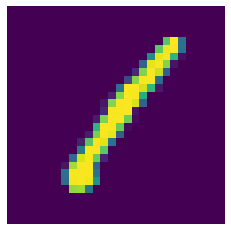

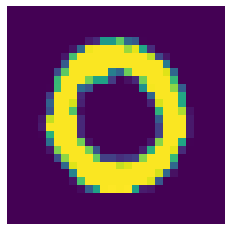

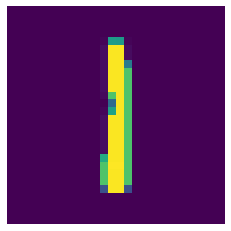

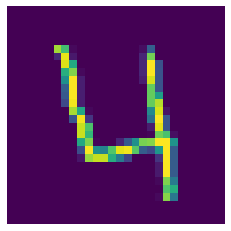

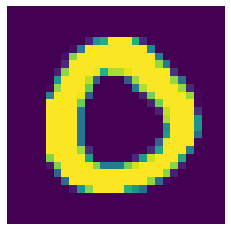

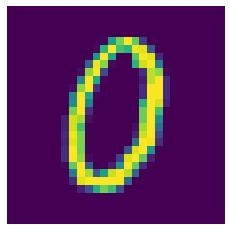

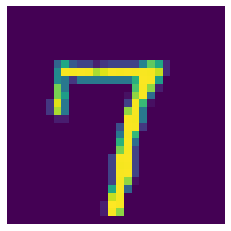

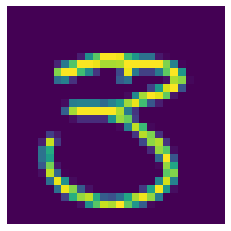

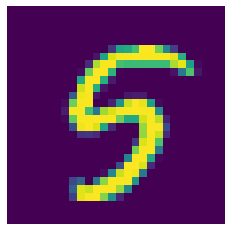

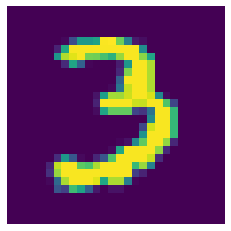

In [55]:
for image in train_data[:10].reshape(-1, 28, 28):
    plt.imshow(image, cmap='viridis')
    plt.axis('off')
    plt.pause(0.1)

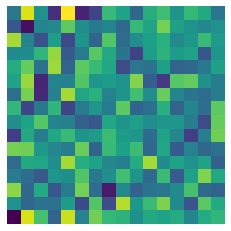

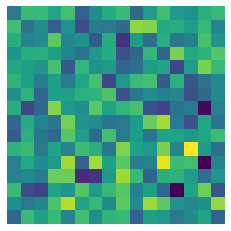

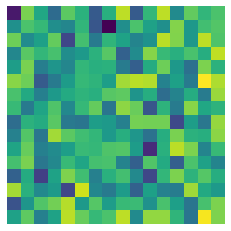

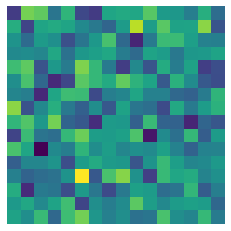

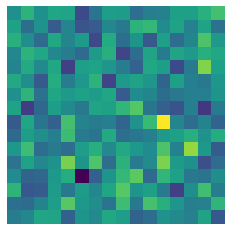

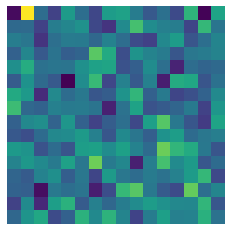

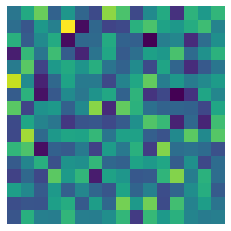

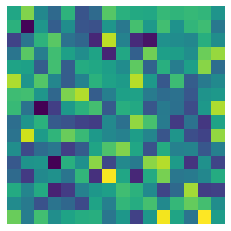

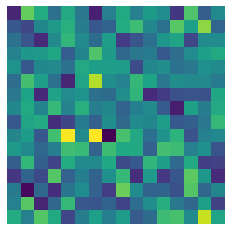

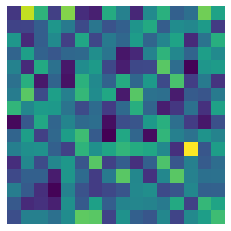

In [56]:
for image in x.reshape(-1, 16, 16):
    plt.imshow(image, cmap='viridis')
    plt.axis('off')
    plt.pause(0.1)

In [57]:
for layer in autoencoder.layers[7:]:
    x = layer(x, False)
x

array([[-0.99931069, -0.9993726 , -0.99936152, ..., -0.99934048,
        -0.99937641, -0.99927566],
       [-0.99931215, -0.99926019, -0.99922072, ..., -0.99927569,
        -0.99920806, -0.99916726],
       [-0.99937167, -0.99929942, -0.99925157, ..., -0.9993076 ,
        -0.9993593 , -0.99932587],
       ...,
       [-0.99970533, -0.99951421, -0.99965512, ..., -0.99964446,
        -0.99960006, -0.99961557],
       [-0.99935408, -0.99933354, -0.99937103, ..., -0.99933022,
        -0.9993481 , -0.99935575],
       [-0.99946466, -0.9994757 , -0.99942124, ..., -0.99946766,
        -0.99940701, -0.99941387]])

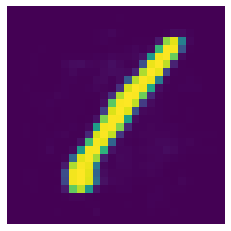

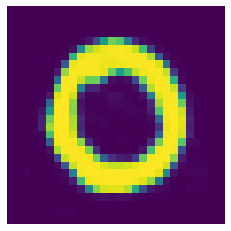

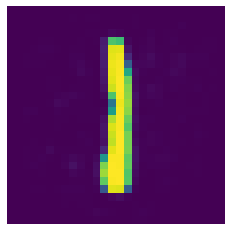

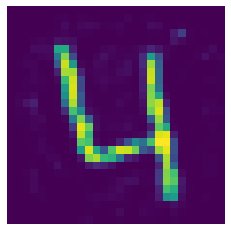

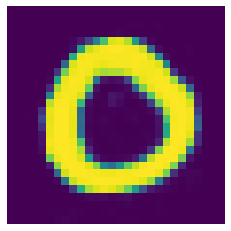

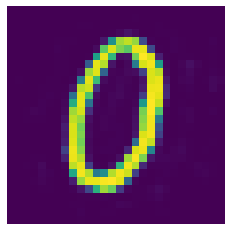

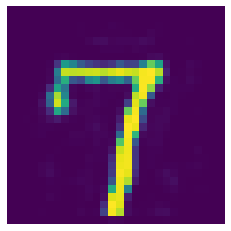

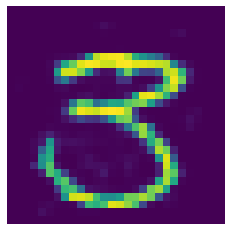

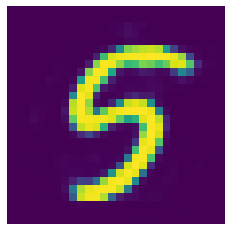

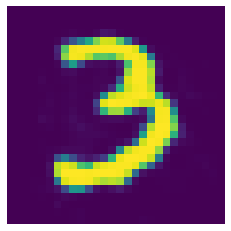

In [58]:
for image in x.reshape(-1, 28, 28):
    plt.imshow(image, cmap='viridis')
    plt.axis('off')
    plt.pause(0.1)

In [59]:
from IPython.display import HTML
with open('./style.css') as f:
    style = f.read()
HTML(style)